# HANC with a Welfare State

**Table of contents**<a id='toc0_'></a>    
- 1. [Setup](#toc1_)    
- 2. [Test 1: Solving and simulating the household problem](#toc2_)    
- 3. [Test 2: Evaluating the objective for finding the steady state](#toc3_)    
- 4. [Find stationary equilibrium](#toc4_)    
- 5. [Grid search](#toc5_)    
- 6. [Policy functions](#toc6_)    
- 7. [Simulation](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HANCWelfareModel import HANCWelfareModelClass
from steady_state import obj_ss

## 1. <a id='toc1_'></a>[Setup](#toc0_)

In [2]:
model = HANCWelfareModelClass(name='baseline')

In [3]:
par = model.par
ss = model.ss

## 2. <a id='toc2_'></a>[Test 1: Solving and simulating the household problem](#toc0_)

We set all the steady values for the household problem manually at ad hoc values:

In [4]:
ss.r = 0.02*(1-0.1)
ss.wt = 1.00*(1-0.3)

We can now solve and simulate:

In [5]:
model.solve_hh_ss(do_print=True)

household problem in ss solved in 0.5 secs [345 iterations]


In [6]:
model.simulate_hh_ss(do_print=True)

household problem in ss simulated in 3.2 secs [399 iterations]


And we can check whether the results make sort of sense:

In [7]:
print(f'{model.ss.A_hh = :.2f}')
print(f'{model.ss.L_hh = :.2f}')
print(f'{model.ss.C_hh = :.2f}')

model.ss.A_hh = 2.03
model.ss.L_hh = 1.06
model.ss.C_hh = 0.78


## 3. <a id='toc3_'></a>[Test 2: Evaluating the objective for finding the steady state](#toc0_)

We can try out various inputs and look at the outputs:

In [8]:
for KL in [2.0,3.0,4.0]:
    clearing_A = obj_ss(KL,model,do_print=False)
    print(f'{KL = :.2f} -> {clearing_A = :12.8f}')

KL = 2.00 -> clearing_A = -102.00780891
KL = 3.00 -> clearing_A = -26.93231728
KL = 4.00 -> clearing_A =   1.95235150


## 4. <a id='toc4_'></a>[Find stationary equilibrium](#toc0_)

In [9]:
model.find_ss(do_print=True)

seaching in [2.9308,4.7940]
steady state found in 14.3 secs
ss.K =  3.389
ss.B =  0.000
ss.A_hh =  3.389
ss.L =  0.923
ss.Y =  1.363
ss.r =  0.021
ss.w =  1.034
ss.clearing_A = -2.66e-15
ss.clearing_L = 0.00e+00
ss.clearing_Y = 1.29e-10


## 5. <a id='toc5_'></a>[Grid search](#toc0_)

In [10]:
par.tau_ss = 0.0
KL_min = ((1/par.beta+par.delta-1)/(par.alpha*par.Gamma))**(1/(par.alpha-1))
KL_max = (par.delta/(par.alpha*par.Gamma))**(1/(par.alpha-1))

In [11]:
NKL = 10
KL_vec = np.hstack((np.linspace(KL_min+1e-2,KL_max-1e-2,NKL),np.linspace(KL_max+1e-2,10.0,NKL)))
clearing_A_vec = np.nan*np.ones(KL_vec.size)
r_vec = np.nan*np.ones(KL_vec.size)

model_ = model.copy()
for i,KL in enumerate(KL_vec):
    print(f'{KL = :6.2f}: ',end='')
    try:
        clearing_A_vec[i] = obj_ss(KL,model_,do_print=False)
        r_vec[i] = model_.ss.r
        print(f'clearing_A = {clearing_A_vec[i]:16.8f}')
    except Exception as e:
        print(e)

KL =   2.93: clearing_A =     -60.20968262
KL =   3.14: clearing_A =     -12.36225697
KL =   3.34: clearing_A =      -4.63492717
KL =   3.55: clearing_A =      -1.21446349
KL =   3.76: clearing_A =       0.65455487
KL =   3.97: clearing_A =       1.80449507
KL =   4.17: clearing_A =       2.58306925
KL =   4.38: clearing_A =       3.15208002
KL =   4.59: clearing_A =       3.59223487
KL =   4.79: clearing_A =       3.95066957
KL =   4.81: clearing_A =       3.98208454
KL =   5.39: clearing_A =       4.73056562
KL =   5.97: clearing_A =       5.32067730
KL =   6.54: clearing_A =       5.84934760
KL =   7.12: clearing_A =       6.34681973
KL =   7.70: clearing_A =       6.82645236
KL =   8.27: clearing_A =       7.29441710
KL =   8.85: clearing_A =       7.75575359
KL =   9.42: clearing_A =       8.21256858
KL =  10.00: clearing_A =       8.66563321


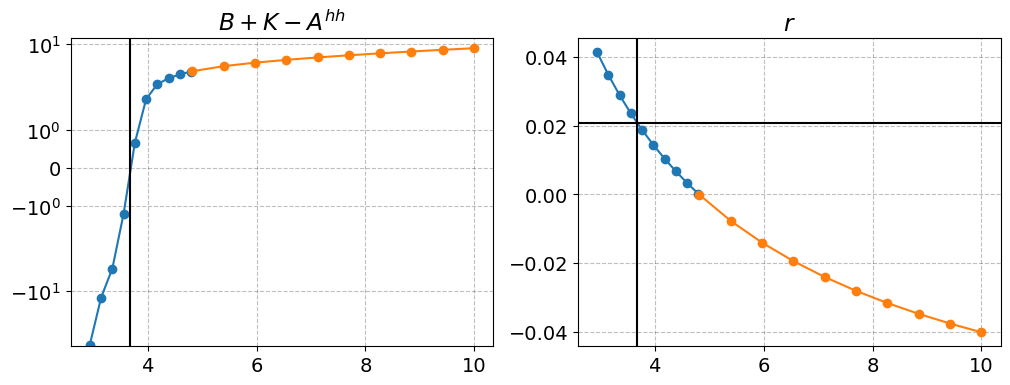

In [12]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('$B+K-A^{hh}$')
ax.plot(KL_vec[:NKL],clearing_A_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],clearing_A_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black')
ax.set_yscale('symlog')

ax = fig.add_subplot(1,2,2)
ax.set_title('$r$')
ax.plot(KL_vec[:NKL],r_vec[:NKL],'-o')
ax.plot(KL_vec[NKL:],r_vec[NKL:],'-o')
ax.axvline(ss.K/ss.L,color='black');
ax.axhline(ss.r,color='black');

## 6. <a id='toc6_'></a>[Policy functions](#toc0_)

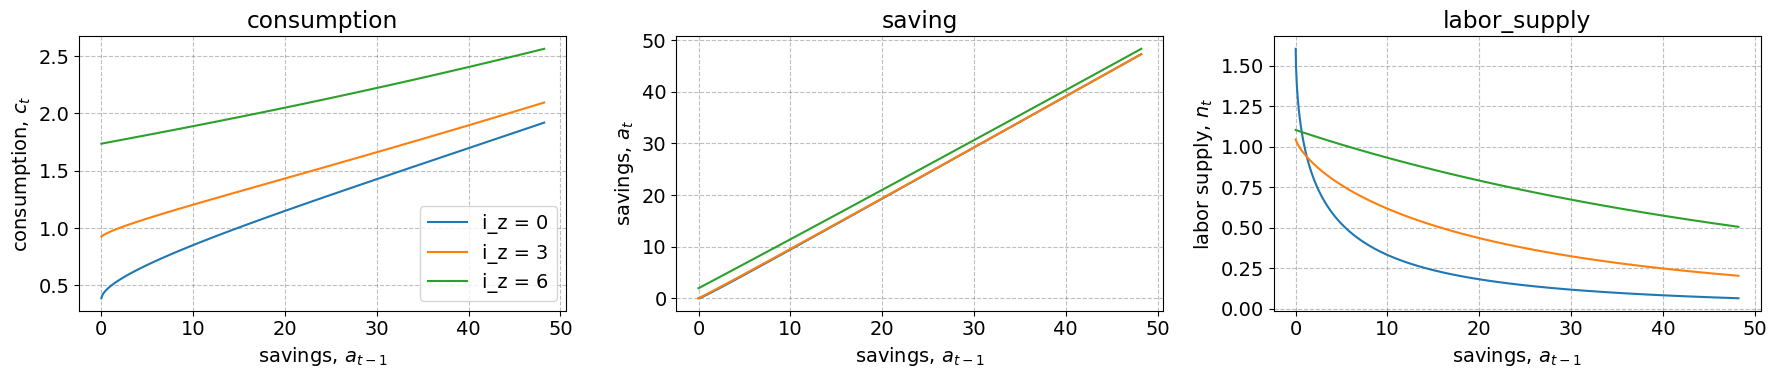

In [13]:
i_fix = 0

fig = plt.figure(figsize=(18,4),dpi=100)
a_max = 50

# a. consumption
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,1)
ax.set_title(f'consumption')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.c[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.legend(frameon=True)
ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('consumption, $c_t$')

# b. saving
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,2)
ax.set_title(f'saving')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.a[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('savings, $a_{t}$')

# c. labor supply
I = par.a_grid < a_max

ax = fig.add_subplot(1,3,3)
ax.set_title(f'labor_supply')

for i_z in [0,par.Nz//2,par.Nz-1]:
    ax.plot(par.a_grid[I],ss.ell[i_fix,i_z,I],label=f'i_z = {i_z}')

ax.set_xlabel('savings, $a_{t-1}$')
ax.set_ylabel('labor supply, $n_{t}$')

fig.tight_layout()
plt.show()

## 7. <a id='toc7_'></a>[Simulation](#toc0_)

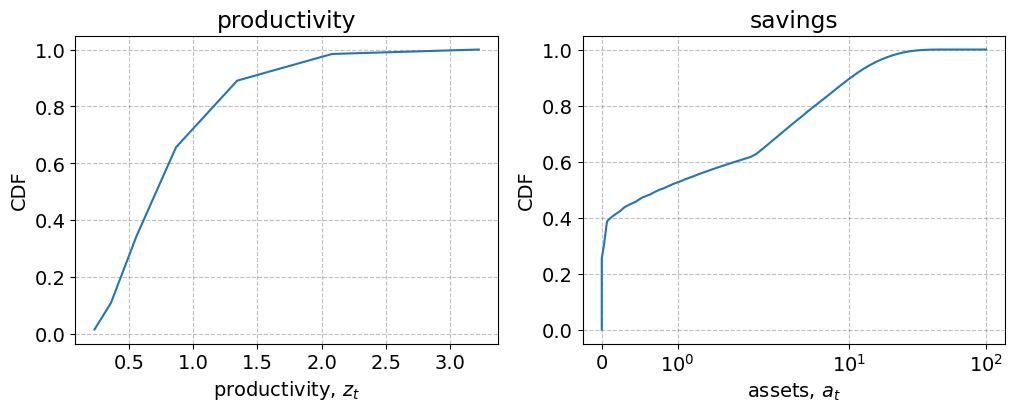

In [14]:
fig = plt.figure(figsize=(12,4),dpi=100)

# a. income
ax = fig.add_subplot(1,2,1)
ax.set_title('productivity')

y = np.cumsum(np.sum(ss.D,axis=(0,2)))
ax.plot(par.z_grid,y/y[-1])

ax.set_xlabel('productivity, $z_{t}$')
ax.set_ylabel('CDF')

# b. assets
ax = fig.add_subplot(1,2,2)
ax.set_title('savings')
y = np.insert(np.cumsum(np.sum(ss.D,axis=(0,1))),0,0.0)
ax.plot(np.insert(par.a_grid,0,par.a_grid[0]),y/y[-1])
        
ax.set_xlabel('assets, $a_{t}$')
ax.set_ylabel('CDF')
ax.set_xscale('symlog')